In [0]:
import sys
import os

Za početak je potrebno u Jupyter okruženje instalirati biblioteke koje će koristiti prilikom izrade projekta. Stoga ćemo instalirati opencv-utils, opencv-python, mtcnn i tensorflow. U narednim isječcima koda date su instalacije tih biblioteka.

In [0]:
!{sys.executable} -m pip install opencv-utils

  Created wheel for opencv-utils: filename=opencv_utils-0.0.2-cp36-none-any.whl size=6108 sha256=18b6f7e66ea0e7a205e735e580073d427a785ffa63b73429af7712155d7d9a78
  Stored in directory: /root/.cache/pip/wheels/c2/f2/f4/479261efe602328ce82efcd408e11364ba0d311175971f38d7
Successfully built opencv-utils


In [0]:
!{sys.executable} -m pip install opencv-python

In [0]:
!{sys.executable} -m pip install mtcnn

     |████████████████████████████████| 2.3MB 4.9MB/s 


In [0]:
!{sys.executable} -m pip install tensorflow

Projekat se okvirno može podijeliti u tri dijela. U prvom dijelu projekta potrebno je pripremiti dataset, drugi dio projekta predtavljao bi treniranje a treći verifikaciju. Stoga se pozabavimo prvim dijelom projekta, odnosno predprocesiranjem dataset-a i pripremanjem istog za korištenje u treniranju i validaciji. U Jupyter notebook-ovim fajlovima kreiran je folder pod nazivom sveslike u kojem su uploadovane fotografije iz dataset-a. 
Ove slike je potrebno učitati u kod. Uz pomoć narednog koda ćemo učitati imena slika u listu fajlovi.

In [0]:
from os import listdir
from os.path import isfile, join
import zipfile

zf = zipfile.ZipFile("utkcropped.zip")
zf.extractall('/content/sveslike')

fajlovi = [f for f in listdir('/content/sveslike') if isfile(join('/content/sveslike', f))]

Kada u listi imamo imena slika svog dataset-a, ove slike ćemo funkcijom imread() učitati u listu sa nazivom slike.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
#from matplotlib import ticker
from mtcnn import MTCNN
import cv2

slike=list()
for i in range(0,len(fajlovi)):
  img = cv2.cvtColor(cv2.imread('/content/sveslike/'+fajlovi[i]), cv2.COLOR_BGR2RGB)
  slike.append(img)

Using TensorFlow backend.


Učitali smo fotografije i sada se treba preći na pretprocesiranje. Iz biblioteke MTCNN koristit ćemo funkciju detect_faces(). Ukoliko se ne detektuje niti jedno lice na slici potrebno je da tu sliku uklonimo.

In [0]:
detector = MTCNN()
lista=list()
for i in range(0,len(slike)):
  if len(detector.detect_faces(slike[i]))==0:
    lista.append(i)
lista.sort(reverse=True)
for i in lista:
  fajlovi.pop(i)

Konačno, pretprocesirani dataset možemo podijeliti u dva dijela, jedan za trening a drugi za verifikaciju. Dataset možemo podijeliti u omjeru 80%:20% za trening:verifikaciju. Pošto su fotografije sortirane redom po godinama osobe na slici, kako bi u oba seta bila ravnomjerno raspoređena količina osoba po godinama, svaki peti element ćemo ubaciti u set za verifikaciju, a sve ostale u set za treniranje.

In [0]:
brver=int(len(fajlovi)/5)+1
brtren=len(fajlovi)-brver
verifikacija=np.ndarray((brver,3,64,64),dtype=np.uint8)
trening=np.ndarray((brtren,3,64,64),dtype=np.uint8)
yver=np.ndarray(brver,dtype=np.uint8)
ytren=np.ndarray(brtren,dtype=np.uint8)
for i in range(0,len(fajlovi)):
  #img = cv2.cvtColor(cv2.imread('/content/sveslike/'+fajlovi[i]), cv2.COLOR_BGR2RGB)
  img = cv2.imread('/content/sveslike/'+fajlovi[i], cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
  img=cv2.resize(img, (64, 64), interpolation=cv2.INTER_CUBIC)
  #img=img/255
  a=fajlovi[i].find('_')+1
  b=fajlovi[i].find('_',a,len(fajlovi[i]))
  if i%5==0:
    verifikacija[int(i/5)]=img.T
    yver[int(i/5)]=fajlovi[i][a:b]
  else:
    trening[i-int(i/5)-1]=img.T
    ytren[i-int(i/5)-1]=fajlovi[i][a:b]

In [0]:
trenbrver=int(brtren/5)+1
trenbrtren=brtren-trenbrver
treningver=np.ndarray((trenbrver,3,64,64),dtype=np.uint8)
treningtren=np.ndarray((trenbrtren,3,64,64),dtype=np.uint8)
trenyver=np.ndarray(trenbrver,dtype=np.uint8)
trenytren=np.ndarray(trenbrtren,dtype=np.uint8)
for i in range(0,brtren):
  if i%5==0:
    treningver[int(i/5)]=trening[i]
    trenyver[int(i/5)]=ytren[i]
  else:
    treningtren[i-int(i/5)-1]=trening[i]
    trenytren[i-int(i/5)-1]=ytren[i]
trenver=(treningver, trenyver)

In [0]:
from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

lr=1e-4
brepoha=30
optimizer = Adam(lr=lr, decay=lr/brepoha)
objective = 'binary_crossentropy'

model = Sequential()

model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(3, 64, 64), activation='relu'))
model.add(Convolution2D(32, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))

model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(Convolution2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))

model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
model.add(Convolution2D(128, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))

model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), dim_ordering="th"))



model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(3, 64, 64..., activation="relu", padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_first")`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", paddi

In [0]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 3, 64, 32)         18464     
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 3, 64, 32)         9248      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 3, 32, 16)         0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 3, 32, 64)         9280      
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 3, 32, 64)         36928     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 3, 16, 32)         0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 3, 16, 128)       

In [0]:
#brepoha = 30
batch_size = 16
#labs = train_data.iloc[:,1].values.tolist()

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')  
history = LossHistory()

In [0]:
model.fit(treningtren, trenytren, batch_size=batch_size, epochs=brepoha, validation_data=trenver, verbose=0, shuffle=True, callbacks=[history, early_stopping])


Epoch 00015: early stopping


In [0]:
predikcije = model.predict(verifikacija, verbose=0)
predikcije

array([[9.9939847e-01],
       [7.8082085e-06],
       [2.1223006e-01],
       ...,
       [2.7984381e-05],
       [9.9259675e-01],
       [2.3508422e-02]], dtype=float32)

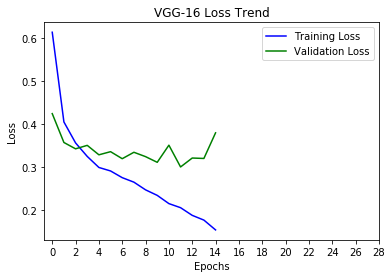

In [0]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,brepoha)[0::2])
plt.legend()
plt.show()

I am 99.94% sure this is a Female


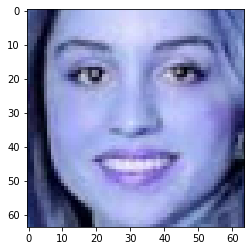

I am 100.00% sure this is a Male


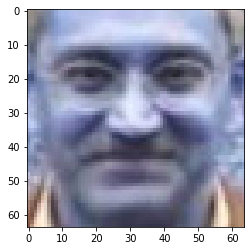

I am 78.78% sure this is a Male


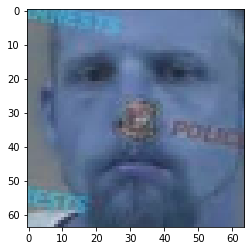

I am 99.75% sure this is a Male


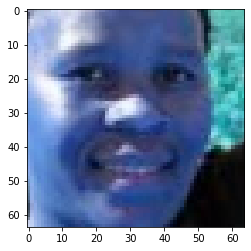

I am 100.00% sure this is a Male


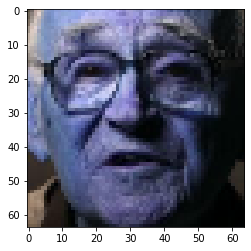

I am 70.76% sure this is a Female


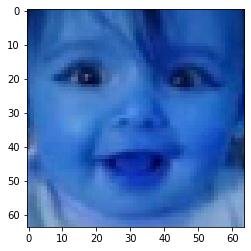

I am 99.95% sure this is a Male


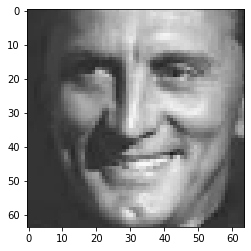

I am 98.63% sure this is a Male


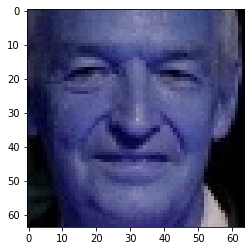

I am 98.21% sure this is a Female


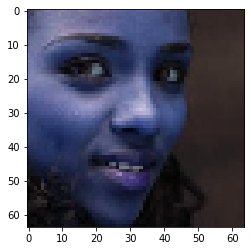

I am 89.00% sure this is a Female


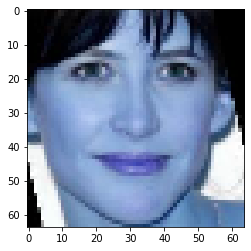

I am 99.75% sure this is a Female


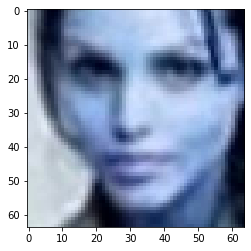

I am 93.53% sure this is a Female


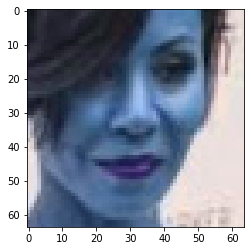

I am 100.00% sure this is a Male


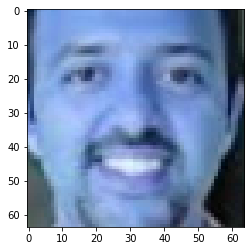

I am 99.49% sure this is a Female


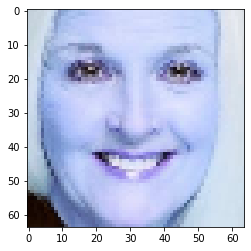

I am 91.17% sure this is a Male


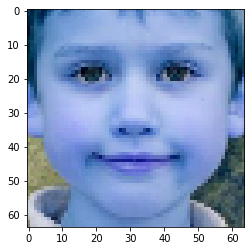

I am 64.10% sure this is a Female


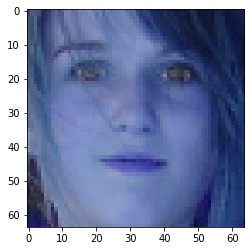

I am 99.96% sure this is a Male


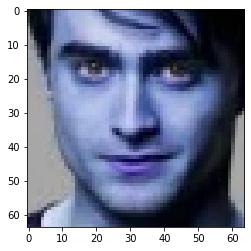

I am 100.00% sure this is a Male


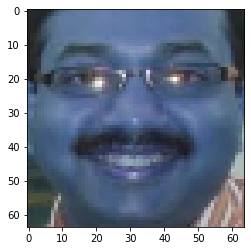

I am 99.94% sure this is a Female


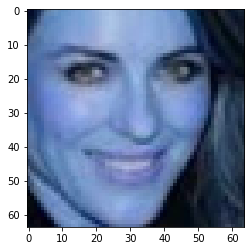

I am 97.23% sure this is a Male


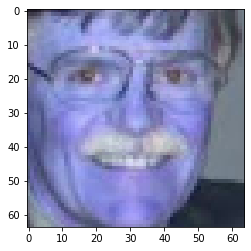

I am 80.90% sure this is a Male


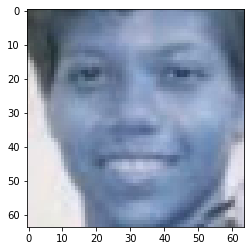

I am 97.77% sure this is a Female


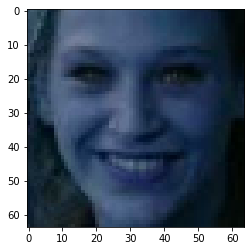

I am 100.00% sure this is a Male


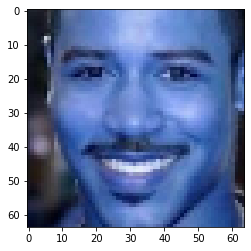

I am 100.00% sure this is a Male


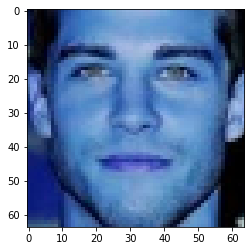

I am 99.98% sure this is a Female


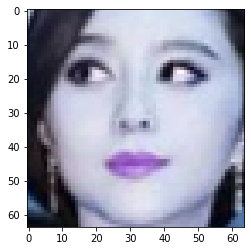

I am 100.00% sure this is a Male


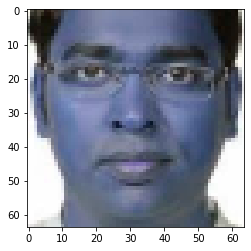

I am 87.40% sure this is a Female


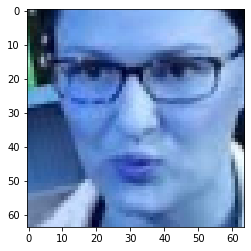

I am 57.84% sure this is a Female


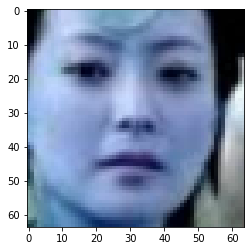

I am 100.00% sure this is a Male


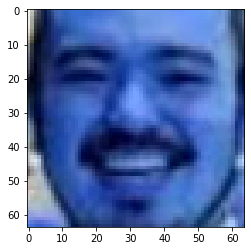

I am 74.01% sure this is a Female


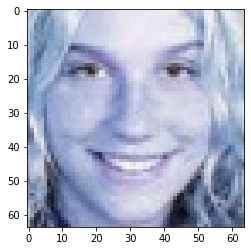

I am 100.00% sure this is a Male


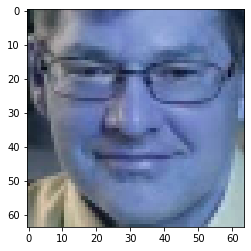

I am 99.51% sure this is a Male


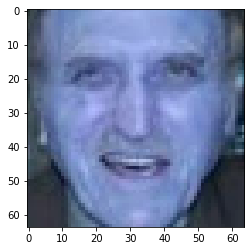

I am 100.00% sure this is a Male


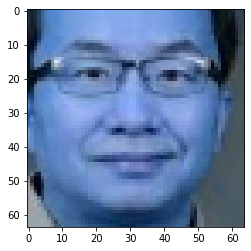

I am 94.04% sure this is a Male


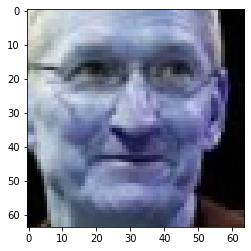

I am 100.00% sure this is a Male


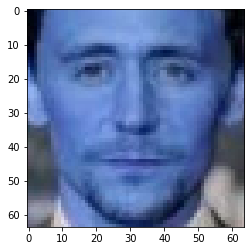

I am 95.84% sure this is a Female


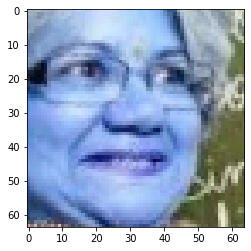

I am 100.00% sure this is a Male


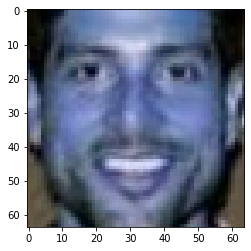

I am 76.97% sure this is a Male


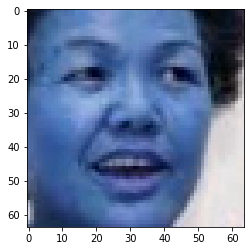

I am 98.12% sure this is a Female


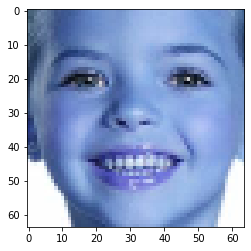

I am 99.79% sure this is a Male


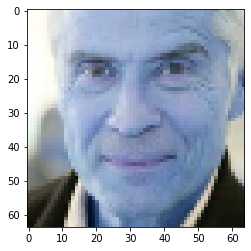

I am 100.00% sure this is a Male


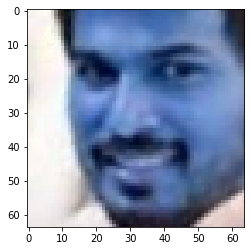

I am 100.00% sure this is a Male


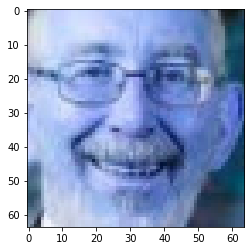

I am 99.96% sure this is a Female


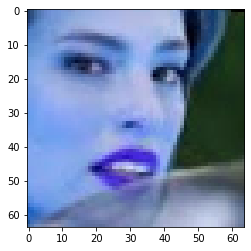

I am 100.00% sure this is a Male


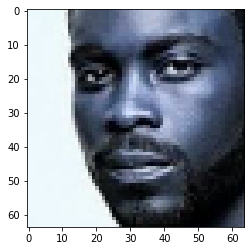

I am 86.23% sure this is a Male


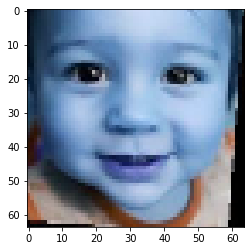

I am 100.00% sure this is a Male


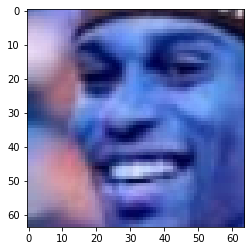

I am 99.20% sure this is a Male


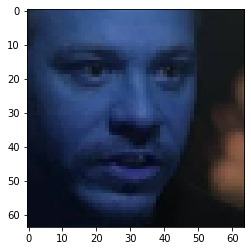

I am 99.94% sure this is a Male


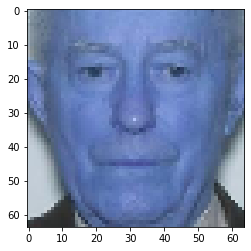

I am 82.59% sure this is a Female


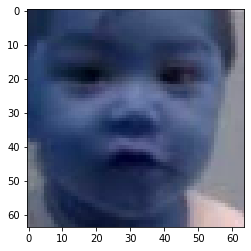

I am 99.99% sure this is a Male


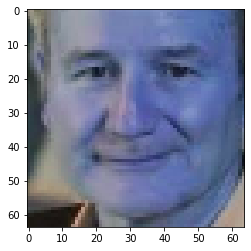

I am 99.66% sure this is a Female


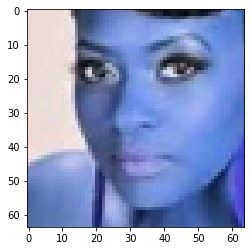

I am 100.00% sure this is a Male


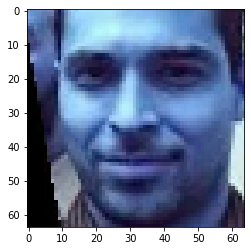

I am 97.86% sure this is a Female


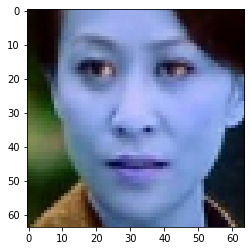

I am 96.55% sure this is a Female


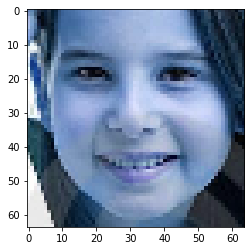

I am 100.00% sure this is a Male


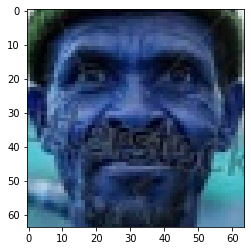

I am 86.19% sure this is a Male


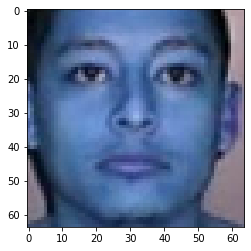

I am 100.00% sure this is a Male


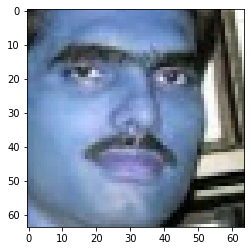

I am 77.29% sure this is a Male


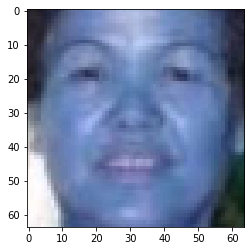

I am 85.20% sure this is a Male


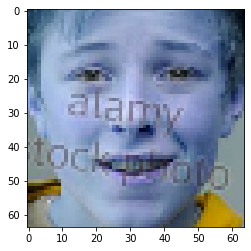

I am 99.98% sure this is a Female


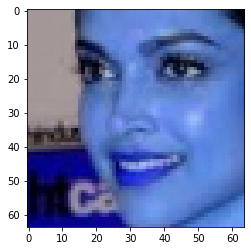

I am 99.31% sure this is a Female


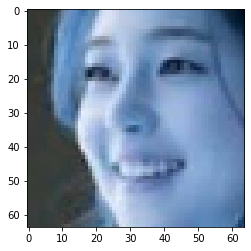

I am 99.93% sure this is a Female


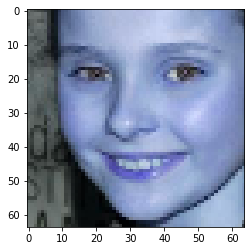

I am 90.62% sure this is a Male


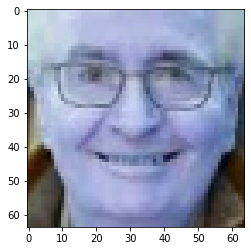

I am 100.00% sure this is a Male


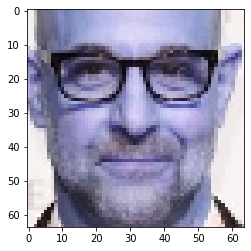

I am 58.38% sure this is a Female


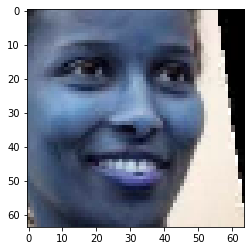

I am 99.45% sure this is a Male


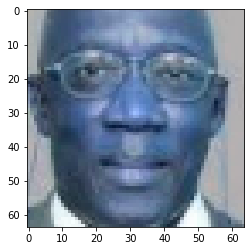

I am 100.00% sure this is a Male


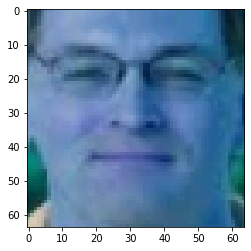

I am 79.71% sure this is a Female


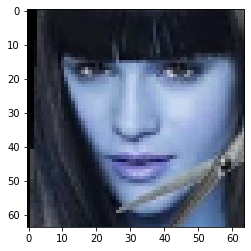

I am 98.05% sure this is a Male


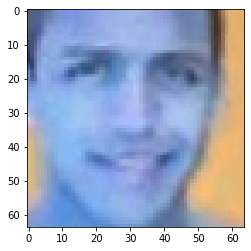

I am 97.79% sure this is a Male


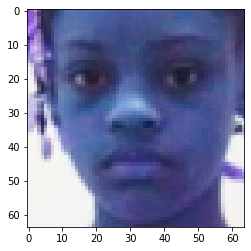

I am 99.96% sure this is a Male


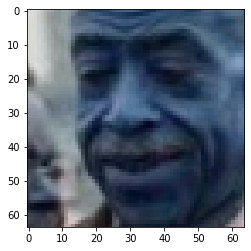

I am 99.92% sure this is a Female


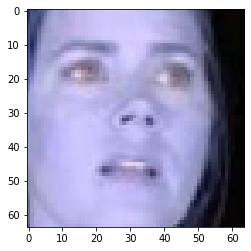

I am 99.98% sure this is a Male


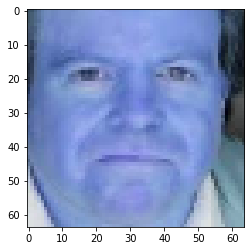

I am 99.99% sure this is a Male


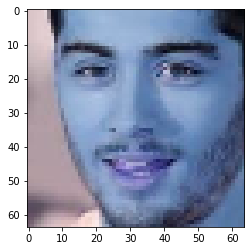

I am 96.42% sure this is a Male


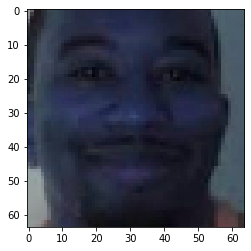

I am 96.08% sure this is a Female


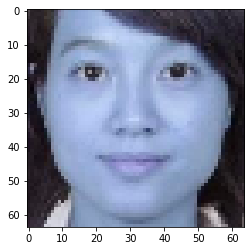

I am 99.82% sure this is a Male


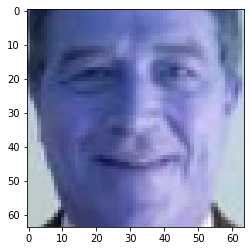

I am 98.72% sure this is a Female


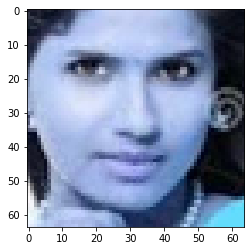

I am 81.04% sure this is a Male


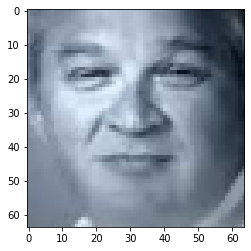

I am 99.44% sure this is a Male


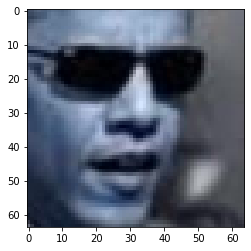

I am 100.00% sure this is a Male


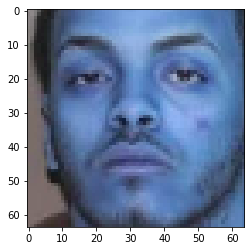

I am 69.20% sure this is a Female


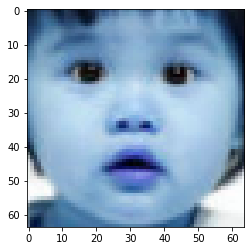

I am 94.36% sure this is a Female


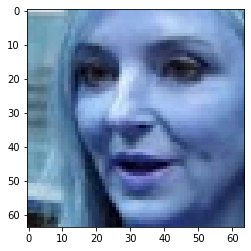

I am 99.76% sure this is a Female


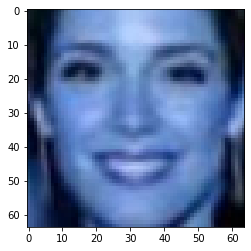

I am 90.60% sure this is a Male


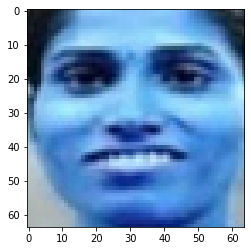

I am 67.23% sure this is a Female


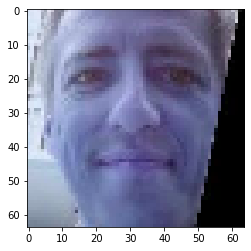

I am 98.34% sure this is a Female


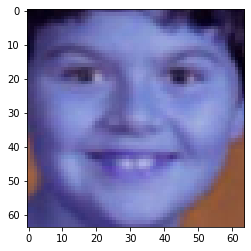

I am 72.23% sure this is a Female


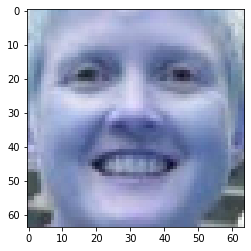

I am 99.97% sure this is a Female


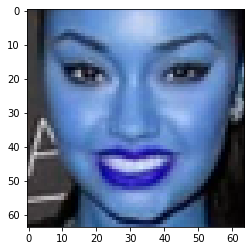

I am 99.63% sure this is a Female


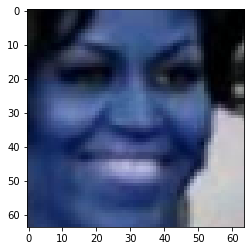

I am 98.21% sure this is a Male


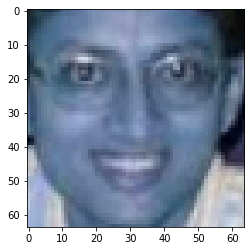

I am 98.67% sure this is a Male


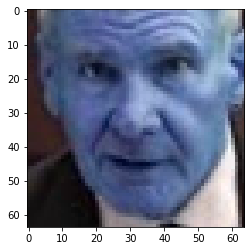

I am 57.03% sure this is a Male


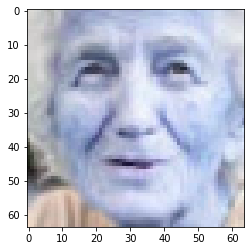

I am 99.76% sure this is a Female


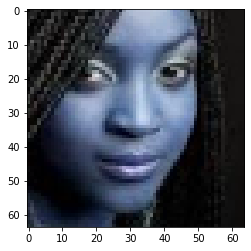

I am 99.90% sure this is a Male


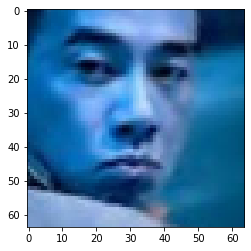

I am 75.60% sure this is a Female


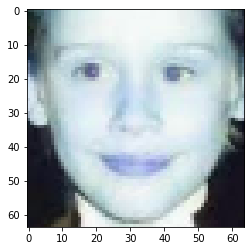

I am 80.33% sure this is a Female


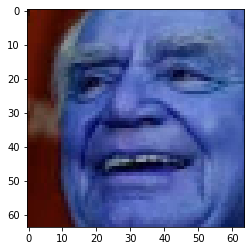

I am 100.00% sure this is a Male


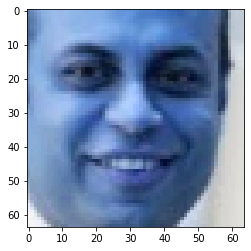

I am 100.00% sure this is a Female


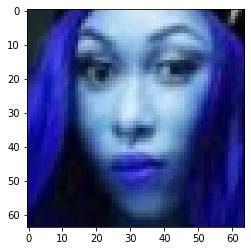

I am 100.00% sure this is a Female


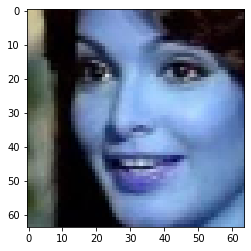

I am 100.00% sure this is a Male


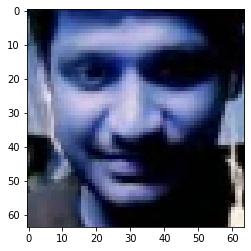

I am 99.94% sure this is a Female


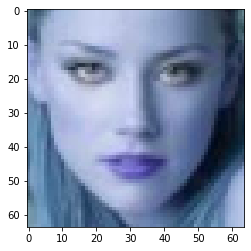

I am 99.03% sure this is a Female


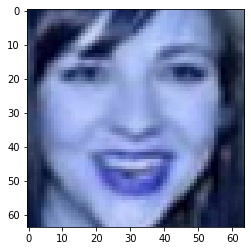

I am 87.03% sure this is a Male


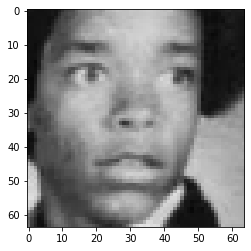

I am 100.00% sure this is a Male


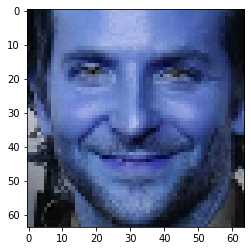

I am 99.92% sure this is a Male


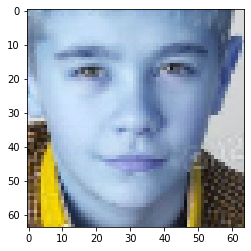

I am 99.99% sure this is a Male


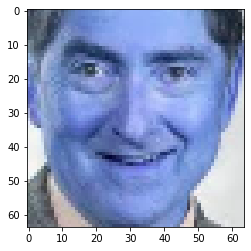

I am 72.74% sure this is a Male


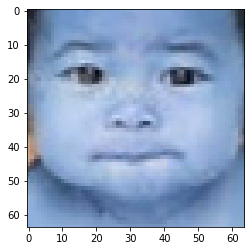

I am 100.00% sure this is a Female


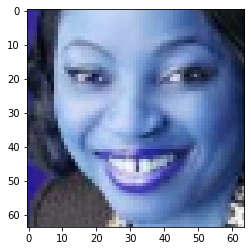

I am 100.00% sure this is a Male


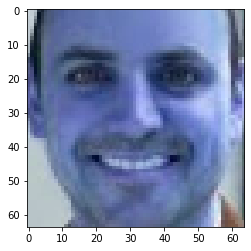

I am 100.00% sure this is a Male


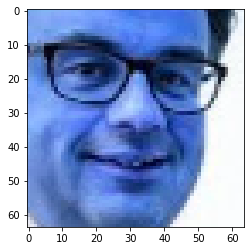

I am 76.71% sure this is a Female


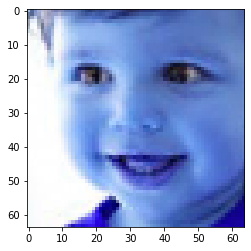

I am 100.00% sure this is a Male


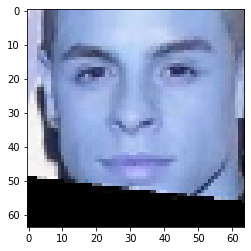

I am 93.78% sure this is a Female


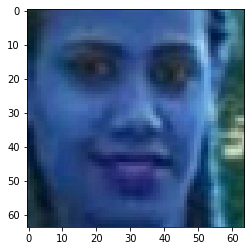

I am 100.00% sure this is a Male


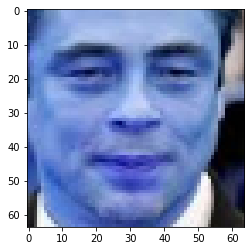

I am 100.00% sure this is a Male


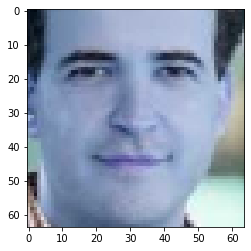

I am 99.77% sure this is a Male


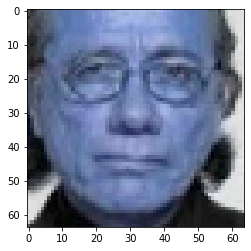

I am 99.98% sure this is a Male


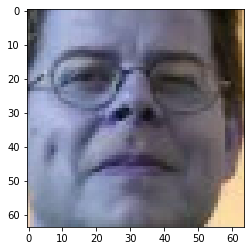

I am 99.98% sure this is a Female


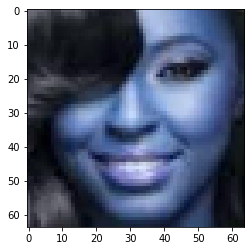

I am 99.97% sure this is a Male


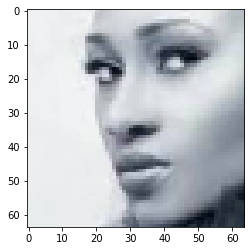

I am 99.94% sure this is a Male


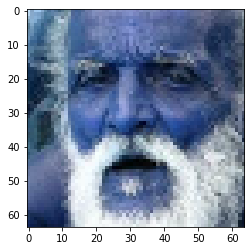

I am 51.62% sure this is a Female


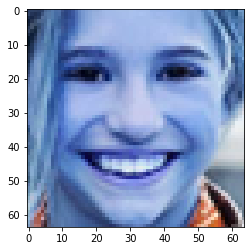

I am 99.77% sure this is a Female


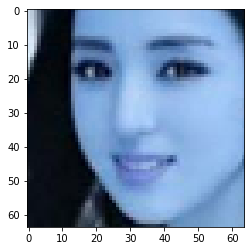

I am 99.68% sure this is a Female


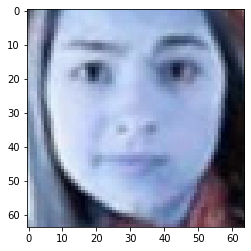

I am 86.26% sure this is a Female


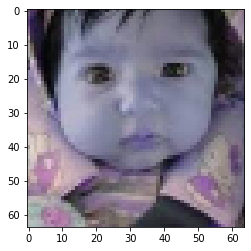

I am 77.70% sure this is a Female


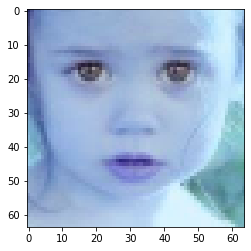

I am 99.47% sure this is a Female


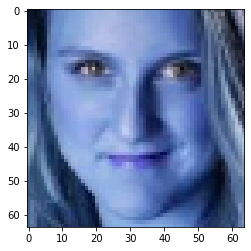

I am 72.61% sure this is a Female


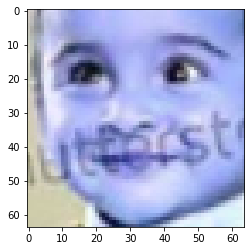

I am 100.00% sure this is a Male


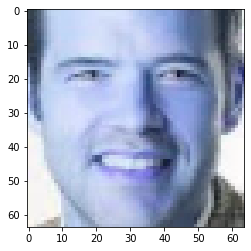

I am 100.00% sure this is a Male


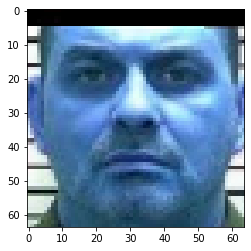

I am 99.85% sure this is a Female


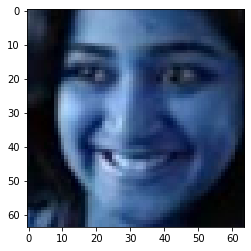

I am 100.00% sure this is a Male


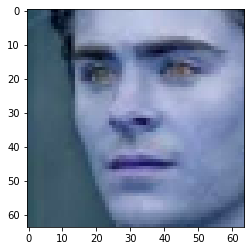

I am 99.76% sure this is a Male


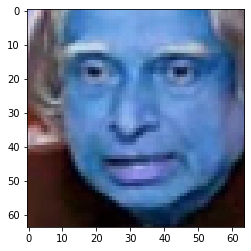

I am 99.99% sure this is a Male


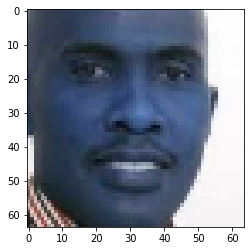

I am 100.00% sure this is a Male


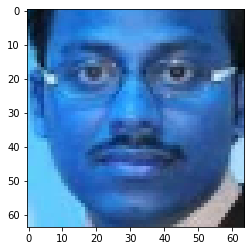

I am 97.91% sure this is a Female


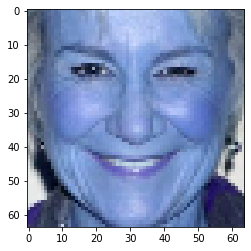

I am 99.98% sure this is a Female


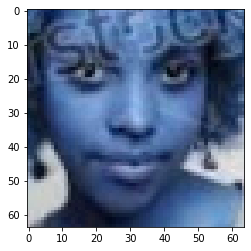

I am 99.11% sure this is a Female


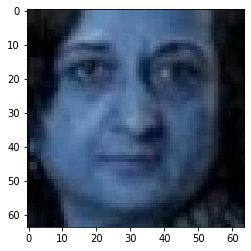

I am 97.38% sure this is a Male


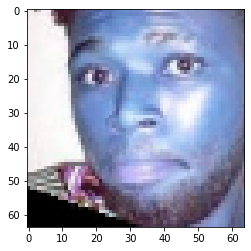

I am 99.78% sure this is a Male


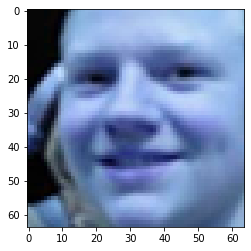

I am 99.62% sure this is a Male


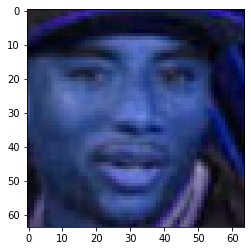

I am 89.55% sure this is a Female


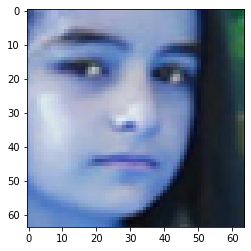

I am 100.00% sure this is a Male


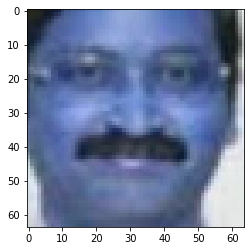

I am 88.35% sure this is a Male


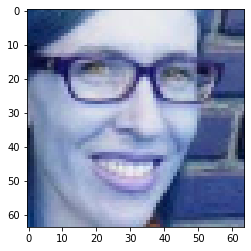

I am 98.28% sure this is a Female


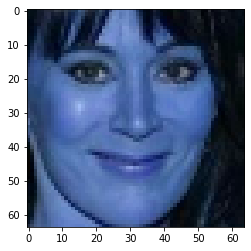

I am 100.00% sure this is a Female


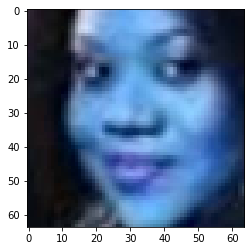

I am 91.70% sure this is a Female


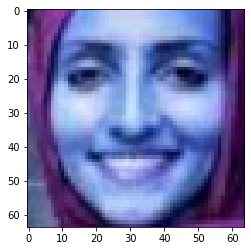

I am 55.17% sure this is a Male


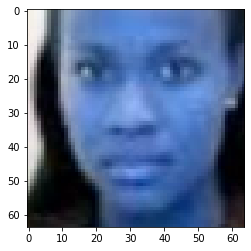

I am 99.97% sure this is a Male


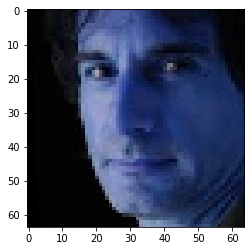

I am 98.56% sure this is a Female


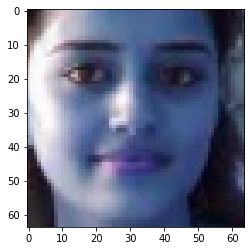

I am 83.67% sure this is a Female


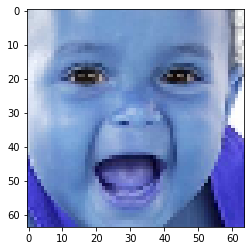

I am 100.00% sure this is a Male


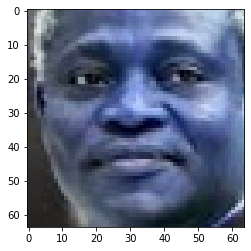

I am 99.96% sure this is a Female


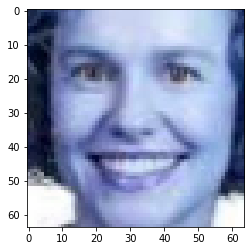

I am 99.15% sure this is a Female


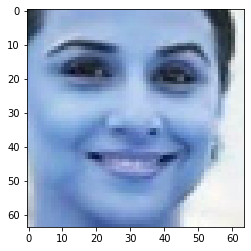

I am 98.92% sure this is a Male


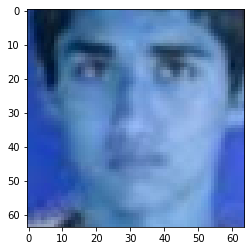

I am 99.93% sure this is a Female


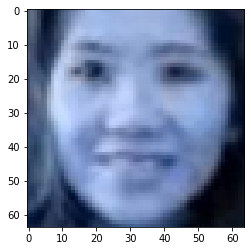

I am 100.00% sure this is a Male


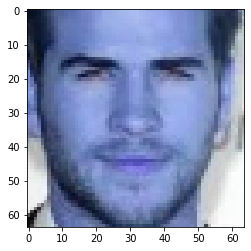

I am 77.02% sure this is a Male


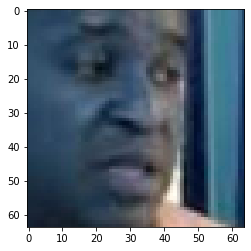

I am 56.39% sure this is a Female


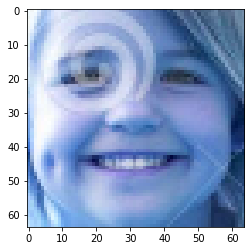

I am 99.98% sure this is a Male


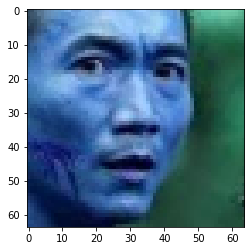

I am 99.39% sure this is a Female


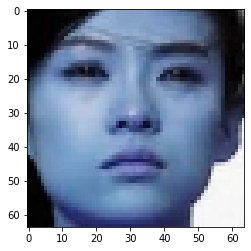

I am 100.00% sure this is a Male


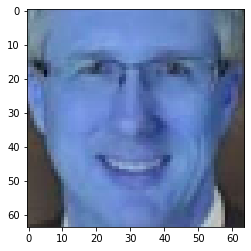

I am 99.89% sure this is a Female


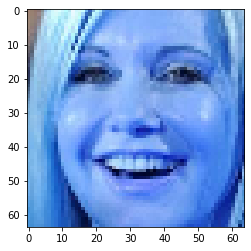

I am 99.95% sure this is a Female


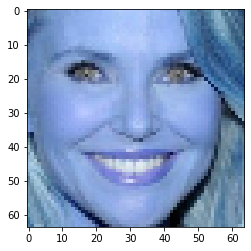

I am 99.59% sure this is a Female


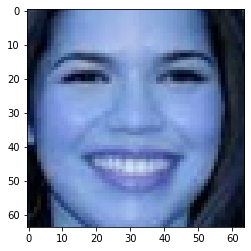

I am 97.57% sure this is a Male


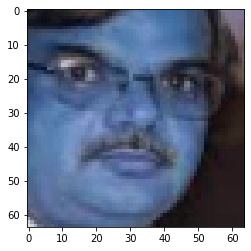

I am 99.65% sure this is a Male


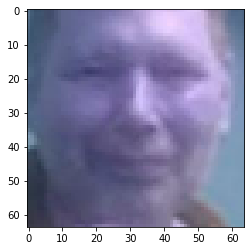

I am 99.80% sure this is a Male


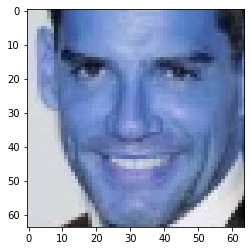

I am 98.69% sure this is a Female


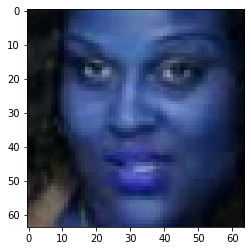

I am 100.00% sure this is a Male


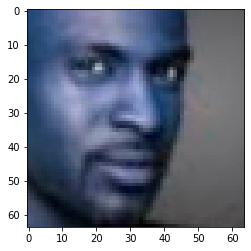

I am 79.87% sure this is a Female


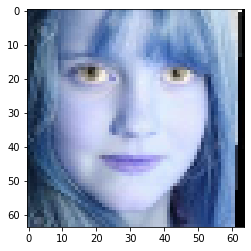

I am 97.71% sure this is a Male


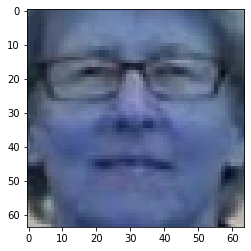

I am 100.00% sure this is a Male


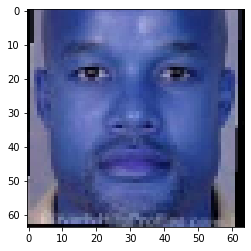

I am 86.50% sure this is a Female


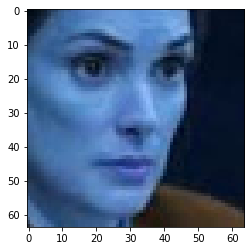

I am 99.44% sure this is a Female


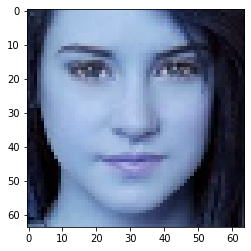

I am 99.99% sure this is a Female


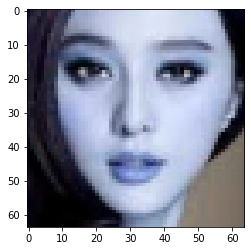

I am 91.66% sure this is a Female


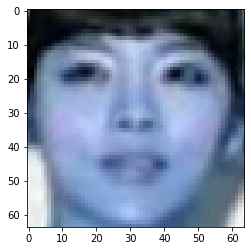

I am 100.00% sure this is a Male


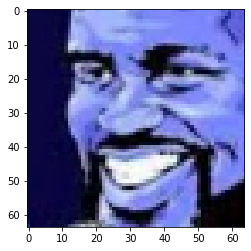

I am 99.92% sure this is a Male


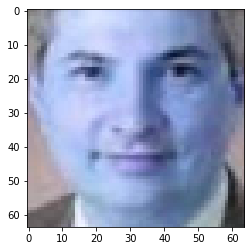

I am 96.95% sure this is a Male


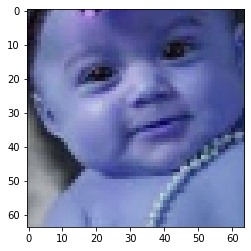

I am 99.94% sure this is a Male


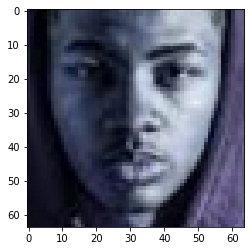

I am 99.99% sure this is a Female


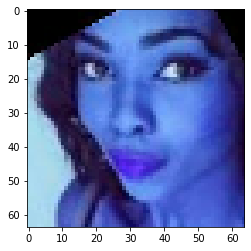

I am 99.83% sure this is a Female


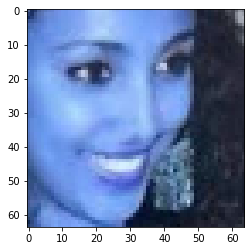

I am 94.72% sure this is a Male


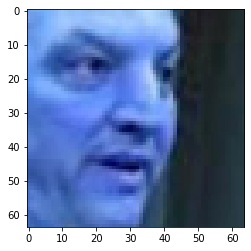

I am 99.96% sure this is a Male


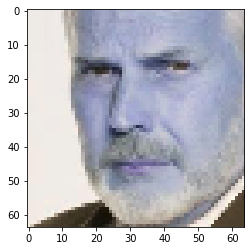

I am 98.89% sure this is a Male


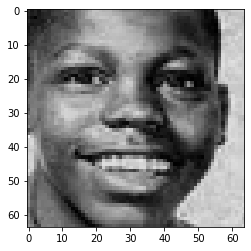

I am 100.00% sure this is a Male


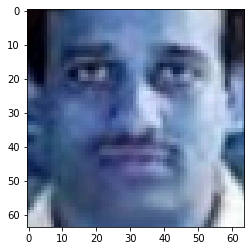

I am 92.38% sure this is a Male


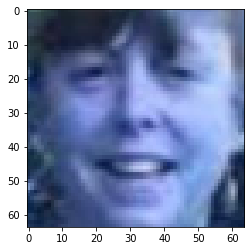

I am 99.98% sure this is a Male


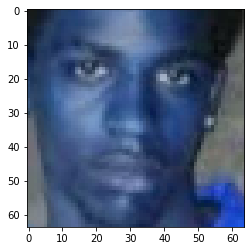

I am 80.98% sure this is a Male


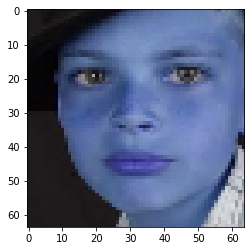

I am 100.00% sure this is a Male


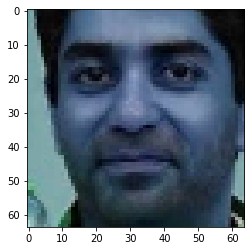

I am 99.57% sure this is a Female


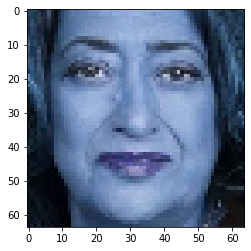

I am 99.95% sure this is a Female


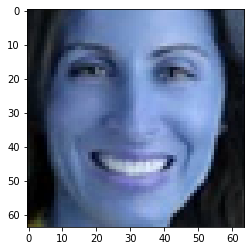

I am 100.00% sure this is a Male


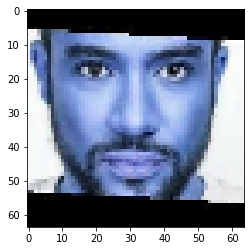

I am 100.00% sure this is a Male


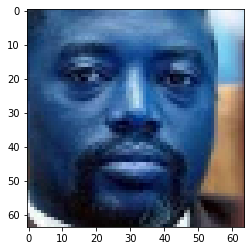

I am 98.36% sure this is a Male


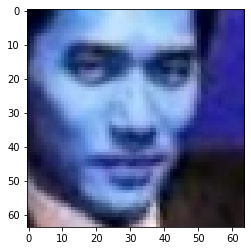

I am 97.37% sure this is a Female


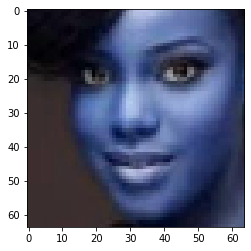

I am 94.35% sure this is a Female


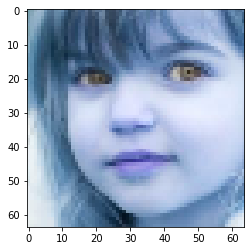

I am 99.83% sure this is a Female


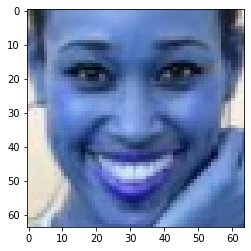

I am 96.11% sure this is a Female


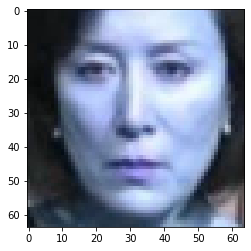

I am 99.92% sure this is a Male


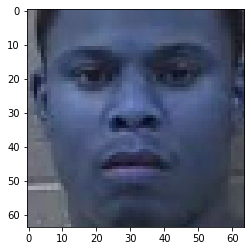

I am 91.00% sure this is a Male


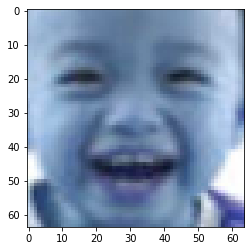

I am 100.00% sure this is a Female


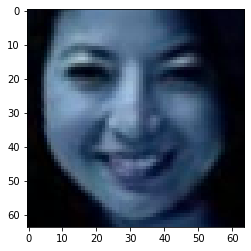

I am 92.38% sure this is a Female


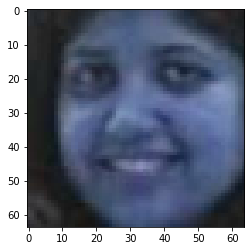

I am 64.11% sure this is a Male


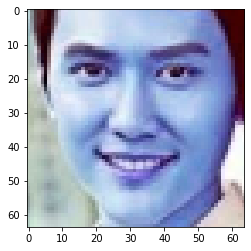

I am 100.00% sure this is a Male


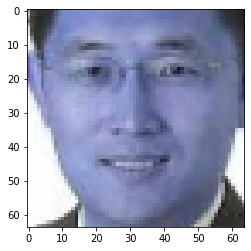

I am 99.47% sure this is a Female


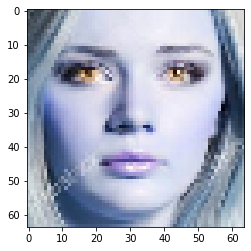

I am 99.98% sure this is a Male


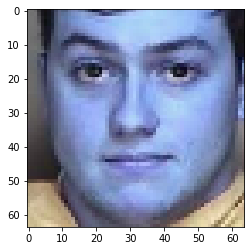

I am 100.00% sure this is a Male


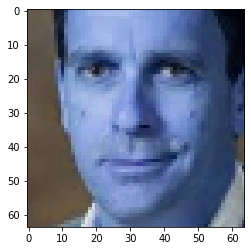

I am 100.00% sure this is a Female


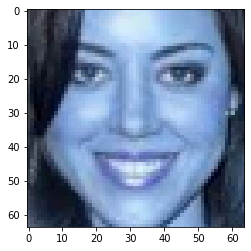

I am 96.65% sure this is a Female


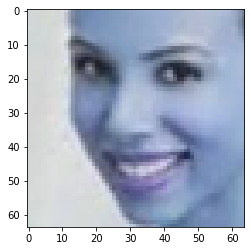

I am 69.75% sure this is a Male


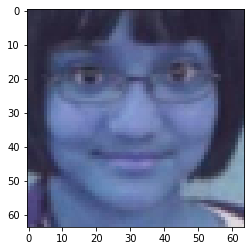

I am 59.37% sure this is a Female


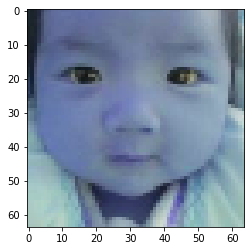

I am 83.38% sure this is a Male


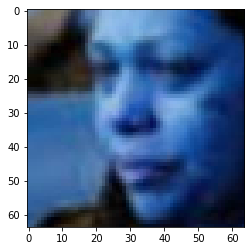

I am 99.84% sure this is a Male


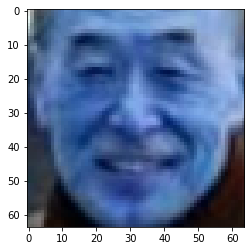

I am 54.33% sure this is a Male


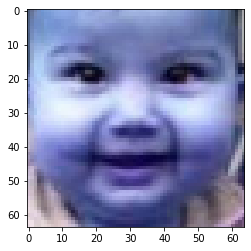

I am 99.86% sure this is a Female


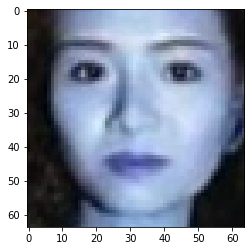

I am 100.00% sure this is a Male


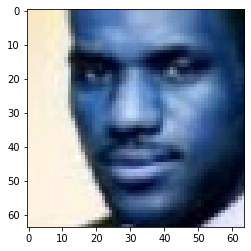

I am 98.99% sure this is a Male


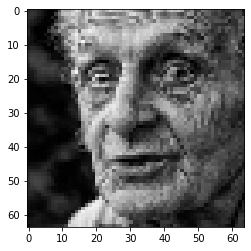

I am 89.71% sure this is a Female


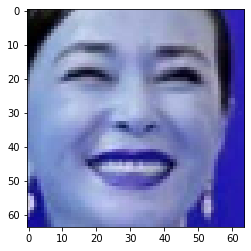

I am 98.23% sure this is a Male


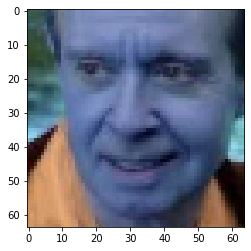

I am 74.58% sure this is a Male


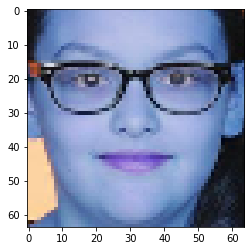

I am 60.00% sure this is a Female


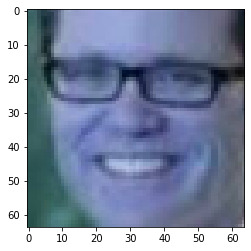

I am 99.87% sure this is a Female


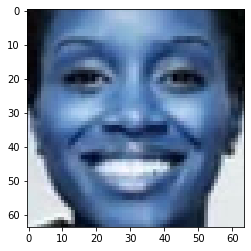

I am 99.99% sure this is a Male


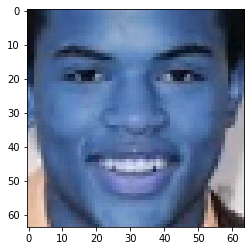

I am 73.98% sure this is a Female


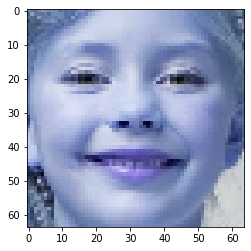

I am 98.81% sure this is a Male


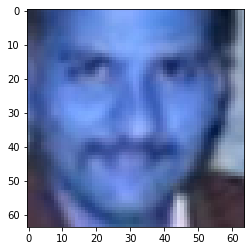

I am 100.00% sure this is a Male


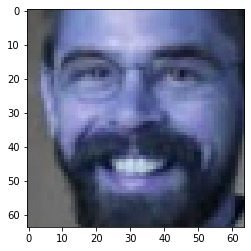

I am 99.95% sure this is a Female


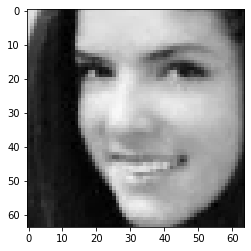

I am 99.84% sure this is a Female


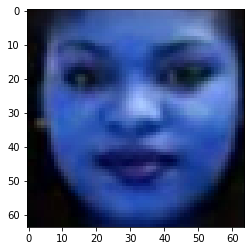

I am 100.00% sure this is a Male


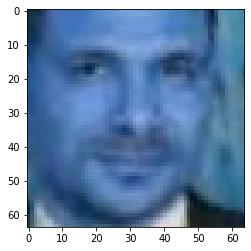

I am 72.39% sure this is a Female


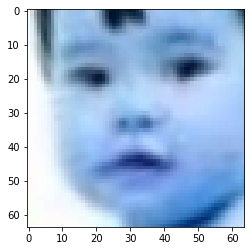

I am 99.72% sure this is a Female


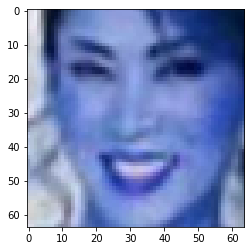

I am 87.57% sure this is a Male


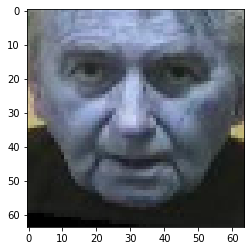

I am 99.99% sure this is a Female


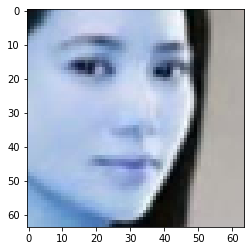

I am 99.82% sure this is a Female


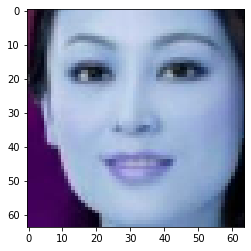

I am 75.40% sure this is a Male


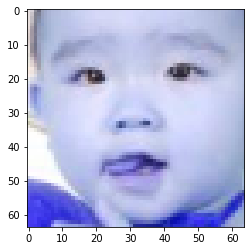

I am 98.78% sure this is a Female


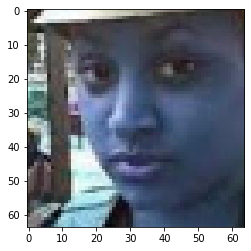

I am 100.00% sure this is a Female


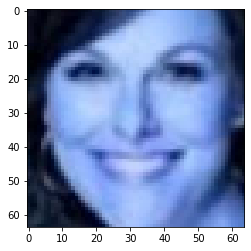

I am 94.81% sure this is a Male


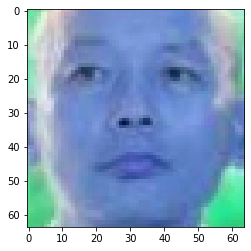

I am 98.37% sure this is a Male


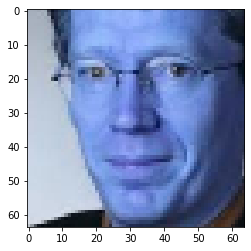

I am 97.29% sure this is a Female


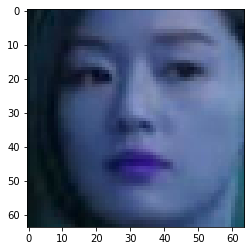

I am 99.64% sure this is a Female


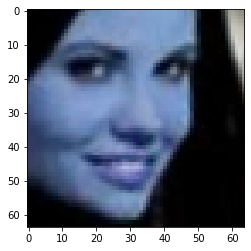

I am 100.00% sure this is a Male


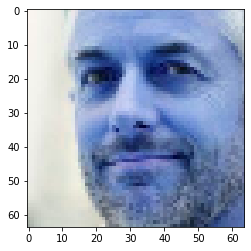

I am 99.72% sure this is a Female


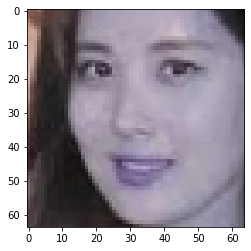

I am 73.70% sure this is a Female


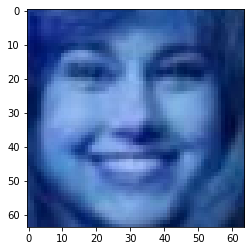

I am 98.18% sure this is a Female


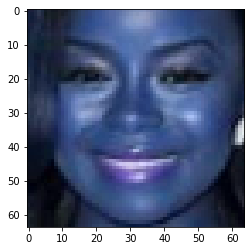

I am 99.89% sure this is a Male


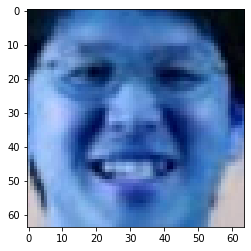

I am 99.64% sure this is a Male


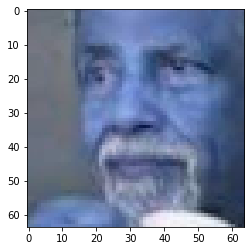

I am 100.00% sure this is a Male


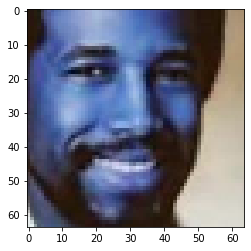

I am 96.07% sure this is a Female


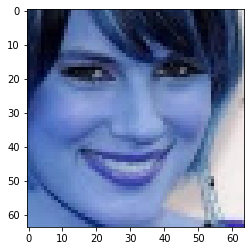

I am 99.98% sure this is a Female


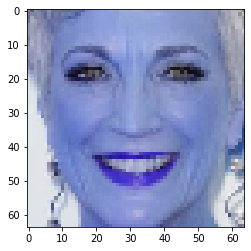

I am 100.00% sure this is a Male


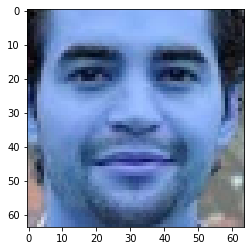

I am 100.00% sure this is a Male


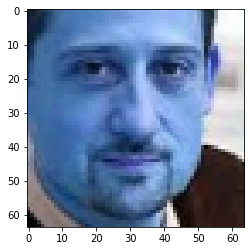

I am 98.83% sure this is a Male


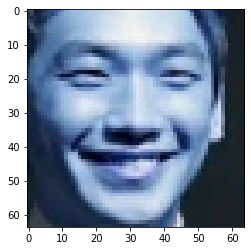

I am 85.75% sure this is a Male


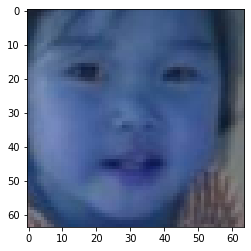

I am 95.51% sure this is a Male


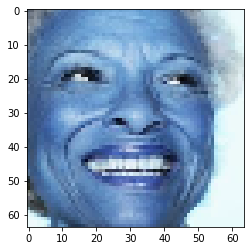

I am 99.97% sure this is a Female


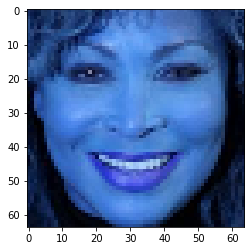

I am 100.00% sure this is a Male


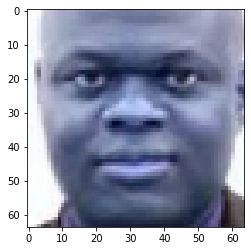

I am 99.92% sure this is a Male


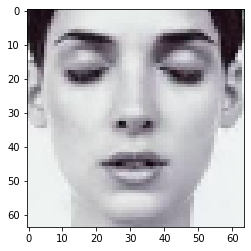

I am 86.74% sure this is a Female


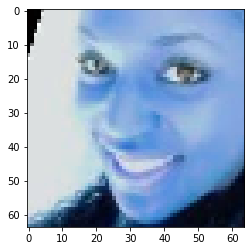

I am 77.23% sure this is a Male


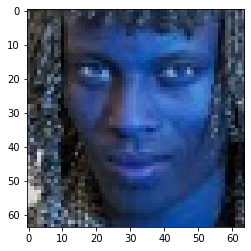

I am 57.30% sure this is a Female


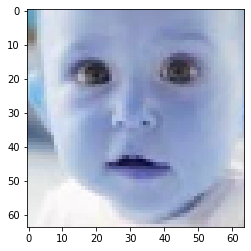

I am 100.00% sure this is a Male


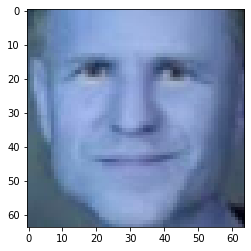

I am 99.78% sure this is a Male


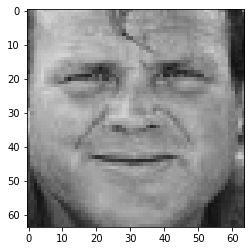

I am 95.74% sure this is a Female


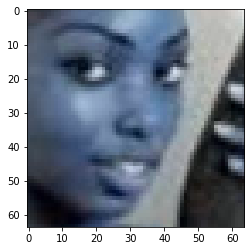

I am 66.43% sure this is a Female


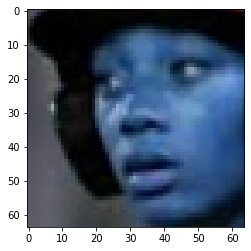

I am 99.87% sure this is a Male


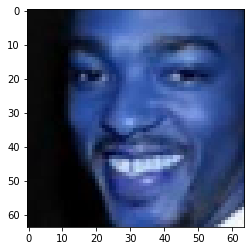

I am 52.45% sure this is a Female


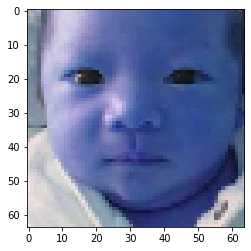

I am 100.00% sure this is a Male


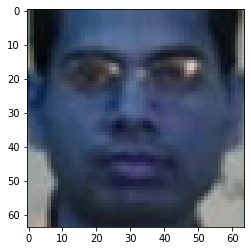

I am 99.84% sure this is a Female


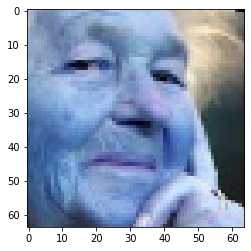

I am 99.95% sure this is a Female


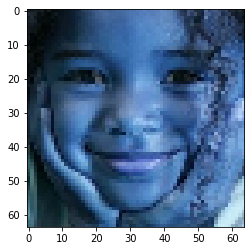

I am 100.00% sure this is a Male


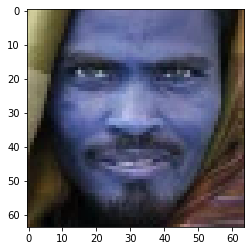

I am 100.00% sure this is a Female


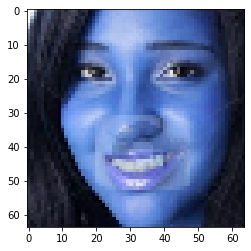

I am 98.30% sure this is a Male


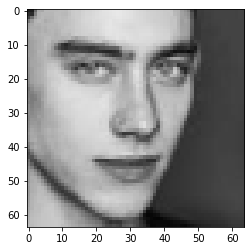

I am 72.94% sure this is a Male


KeyboardInterrupt: ignored

In [0]:
ypredikcije=np.ndarray(len(predikcije),dtype=np.uint8)
for i in range(0,len(verifikacija)):
    if predikcije[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Female'.format(predikcije[i][0]))

    else: 
        print('I am {:.2%} sure this is a Male'.format(1-predikcije[i][0]))
        
    plt.imshow(verifikacija[i].T)
    plt.show()

In [0]:
import collections
type(predikcije)


print((yver==0).sum())
print((yver==1).sum())
print((trenytren==0).sum())
print((trenytren==1).sum())
print((predikcije<0.5).sum())
print((predikcije>=0.5).sum())

pred=np.ndarray(len(predikcije),dtype=np.uint8)
for i in range(0, len(predikcije)):
  if (predikcije[i]<=0.5):
    pred[i]=0
  else:
    pred[i]=1





2451
2238
7852
7148
2523
2166


In [0]:
import sklearn
print(sklearn.metrics.confusion_matrix(yver, pred))
acc=(1629+2041)/(1629+822+197+2041)
acc1=(2203+1450)/(2203+248+788+1450)
acc2=(2174+1889)/(2147+277+349+1889)
print(acc*100)
print(acc1*100)
print(acc2*100)

[[2174  277]
 [ 349 1889]]
78.2682874813393
77.90573683088078
87.15143715143715


In [0]:
2898+1791-1943-1808

938

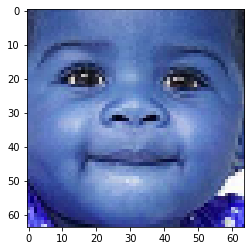

(3, 64, 64)


In [0]:

plt.imshow(verifikacija[7].T)
plt.show()
print(verifikacija[5].shape)

In [0]:
ytren=np.ndarray(5,dtype=np.uint8)
ytren.shape
ytren[0]='1'
ytren[1]='8'
ytren[2]='8'
ytren[3]='1'
ytren[4]='1'
print(ytren)

[1 8 8 1 1]


In [0]:
verifikacija.shape
trening.shape
len(fajlovi)

1041

In [0]:
import collections
print(collections.Counter(yver))
print(collections.Counter(ytren))
print((83/126)*100)
print((359/473)*100)


Counter({0: 126, 1: 83})
Counter({0: 473, 1: 359})
65.87301587301587
75.8985200845666


In [0]:
for j in (range(0,len(fajlovi))):
  if j%5==0:
    j
  else:
    print(j-int(j/5))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [0]:
#BOUNDING BOX
from mtcnn import MTCNN
import cv2

img = cv2.cvtColor(cv2.imread('/content/34_1_1_20170114024710355.jpg.chip.jpg'), cv2.COLOR_BGR2RGB)
detector = MTCNN()
bounding_box=detector.detect_faces(img)[0].get('box')

pt1 = (bounding_box[0], bounding_box[1])
pt2 = (bounding_box[2], bounding_box[3])
cv2.rectangle(img, pt1, pt2, (255, 0, 0),2 )

plt.imshow(img)
plt.show()


In [0]:
from zipfile import ZipFile
with ZipFile('foo.zip', 'r') as zf:
    zf.extractall('destination_path/')

#ILI

from shutil import unpack_archive
unpack_archive('foo.zip', 'destination_path/')

In [0]:
len(slike)

23709

In [0]:
len(fajlovi)

23441

In [0]:
brver

4689

In [0]:
brtren

18752

In [0]:
brver=int(len(fajlovi)/5)+1
brtren=len(fajlovi)-brver
verifikacija=np.ndarray((brver,224,224,3),dtype=np.uint8)
trening=np.ndarray((brtren,224,224,3),dtype=np.uint8)
yver=np.ndarray(brver,dtype=np.uint8)
ytren=np.ndarray(brtren,dtype=np.uint8)
for i in range(0,len(fajlovi)):
  #img = cv2.cvtColor(cv2.imread('/content/sveslike/'+fajlovi[i]), cv2.COLOR_BGR2RGB)
  img = cv2.imread('/content/sveslike/'+fajlovi[i], cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
  img=cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)
  #img=img/255
  a=fajlovi[i].find('_')+1
  b=fajlovi[i].find('_',a,len(fajlovi[i]))
  if i%5==0:
    verifikacija[int(i/5)]=img
    yver[int(i/5)]=fajlovi[i][a:b]
  else:
    trening[i-int(i/5)-1]=img
    ytren[i-int(i/5)-1]=fajlovi[i][a:b]

In [0]:
verifikacija.shape

(4689, 224, 224, 3)

In [0]:
trenbrver=int(brtren/5)+1
trenbrtren=brtren-trenbrver
treningver=np.ndarray((trenbrver,224,224,3),dtype=np.uint8)
treningtren=np.ndarray((trenbrtren,224,224,3),dtype=np.uint8)
trenyver=np.ndarray(trenbrver,dtype=np.uint8)
trenytren=np.ndarray(trenbrtren,dtype=np.uint8)
for i in range(0,brtren):
  if i%5==0:
    treningver[int(i/5)]=trening[i]
    trenyver[int(i/5)]=ytren[i]
  else:
    treningtren[i-int(i/5)-1]=trening[i]
    trenytren[i-int(i/5)-1]=ytren[i]
trenver=(treningver, trenyver)

In [0]:
import keras
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Dense, Activation, Dropout, Flatten, Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Activation
from keras.layers import Conv2D, AveragePooling2D
from keras.models import Model, Sequential
from sklearn.model_selection import train_test_split
from keras import metrics
from keras.models import model_from_json
from keras.optimizers import Adam


model = Sequential()
model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(256, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(ZeroPadding2D((1,1)))
model.add(Convolution2D(512, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2), strides=(2,2)))
 
model.add(Convolution2D(4096, (7, 7), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, (1, 1), activation='relu'))
model.add(Dropout(0.5))
model.add(Convolution2D(2622, (1, 1)))
model.add(Flatten())
model.add(Activation('softmax'))


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
lr=1e-4
brepoha = 250
batch_size = 256
optimizer = Adam(lr=lr, decay=lr/brepoha)
objective = 'binary_crossentropy'
model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 112, 112, 128)    

In [0]:
from keras.callbacks import Callback
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')  
history = LossHistory()

In [0]:
model.fit(treningtren, trenytren, batch_size=batch_size, epochs=brepoha, validation_data=trenver, verbose=0, shuffle=True, callbacks=[history, early_stopping])


ValueError: ignored

In [0]:
#freeze all layers of VGG-Face except last 7 one
for layer in model.layers[:-7]:
    layer.trainable = False

base_model_output = Sequential()
base_model_output = Convolution2D(2, (1, 1), name='predictions')(model.layers[-4].output)
base_model_output = Flatten()(base_model_output)
base_model_output = Activation('softmax')(base_model_output)

gender_model = Model(inputs=model.input, outputs=base_model_output)

In [0]:
#check trainable layers
if False:
    for layer in model.layers:
        print(layer, layer.trainable)
    
    print("------------------------")
    for layer in age_model.layers:
        print(layer, layer.trainable)

In [0]:
sgd = keras.optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)

gender_model.compile(loss='categorical_crossentropy'
                  , optimizer=keras.optimizers.Adam()
                  #, optimizer = sgd
                  , metrics=['accuracy']
                 )

In [0]:
checkpointer = ModelCheckpoint(
    filepath='classification_gender_model.hdf5'
    , monitor = "val_loss"
    , verbose=1
    , save_best_only=True
    , mode = 'auto'
)

In [0]:
scores = []

In [0]:
enableFit = True

if enableFit:
    epochs = 250
    batch_size = 256

    for i in range(epochs):
        print("epoch ",i)
        
        ix_train = np.random.choice(train_x.shape[0], size=batch_size)
        
        score = gender_model.fit(
            train_x[ix_train], train_y[ix_train]
            , epochs=1
            , validation_data=(test_x, test_y)
            , callbacks=[checkpointer]
        )
        
        scores.append(score)
        
        from keras.models import load_model
        gender_model = load_model("classification_gender_model.hdf5")
        
        gender_model.save_weights('gender_model_weights.h5')
        
else:
    #pre-trained weights for gender prediction: https://drive.google.com/file/d/1wUXRVlbsni2FN9-jkS_f4UTUrm1bRLyk/view?usp=sharing
    gender_model.load_weights("gender_model_weights.h5")

In [0]:

from keras.preprocessing import image
img = image.load_img('/content/1_0_0_20161219140642920.jpg.chip.jpg', grayscale=False, target_size=(128,128))
x = image.img_to_array(img).reshape(1, -1)[0]

Using TensorFlow backend.


In [0]:
x

array([189., 159., 107., ..., 201., 201., 203.], dtype=float32)